# Testing loading model output from ACCESS-CM2-025

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm

In [2]:
client = Client()
client

2022-05-31 15:58:56,996 - distributed.diskutils - INFO - Found stale lock file and directory '/local/m68/wgh581/tmp/dask-worker-space/worker-eg497k3u', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39077/status,
Dashboard: /proxy/39077/status,Workers: 1
Total threads: 1,Total memory: 2.81 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39167,Workers: 1
Dashboard: /proxy/39077/status,Total threads: 1
Started: Just now,Total memory: 2.81 GiB
Comm: tcp://127.0.0.1:46427,Total threads: 1
Dashboard: /proxy/39569/status,Memory: 2.81 GiB
Nanny: tcp://127.0.0.1:45757,


In [3]:
session = cc.database.create_session('/g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/cj877.db') 
control = 'cj877'

In [4]:
path_to_data = '/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/'

If you get a 'read-only database' warning, it is because the database has not finished building. 

## Database explorer

In [4]:
from cosima_cookbook import explore
dbx = explore.DatabaseExplorer(session=session) # session=session
dbx

DatabaseExplorer(children=(HTML(value='<style>.header p{ line-height: 1.4; margin-bottom: 10px }</style>\n    …

In [7]:
variables = cc.querying.get_variables(session, experiment=control)
variables

,name,long_name,units,frequency,ncfile,cell_methods,# ncfiles,time_start,time_end
0,ANGLE,angle grid makes with latitude line on U grid,radians,1 daily,history/ice/iceh_d.0400-12.nc,None,4800,0001-01-01 00:00:00,0401-01-01 00:00:00
1,ANGLET,angle grid makes with latitude line on T grid,radians,1 daily,history/ice/iceh_d.0400-12.nc,None,4800,0001-01-01 00:00:00,0401-01-01 00:00:00
2,NCAT,category maximum thickness,m,1 daily,history/ice/iceh_d.0400-12.nc,None,4800,0001-01-01 00:00:00,0401-01-01 00:00:00
3,TLAT,T grid center latitude,degrees_north,1 daily,history/ice/iceh_d.0400-12.nc,None,4800,0001-01-01 00:00:00,0401-01-01 00:00:00
4,TLON,T grid center longitude,degrees_east,1 daily,history/ice/iceh_d.0400-12.nc,None,4800,0001-01-01 00:00:00,0401-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...
324,time,time,days since 0001-01-01 00:00:00,static,history/ocn/ocean-2d-drag_coeff.nc,None,15,0001-01-01 00:00:00,0381-01-01 00:00:00
325,xt_ocean,tcell longitude,degrees_E,static,history/ocn/ocean-2d-dxt.nc,None,7,0001-01-01 00:00:00,0001-01-01 00:00:00
326,xu_ocean,ucell longitude,degrees_E,static,history/ocn/ocean-2d-drag_coeff.nc,None,8,0001-01-01 00:00:00,0381-01-01 00:00:00
327,yt_ocean,tcell latitude,degrees_N,static,history/ocn/ocean-2d-dxt.nc,None,7,0001-01-01 00:00:00,0001-01-01 00:00:00


## Testing loading random variable

In [7]:
start_time = '0001-01-01'
end_time = '0002-12-31'

In [8]:
data = cc.querying.getvar(control, 'sst', session, start_time=start_time, end_time=end_time, frequency='1 monthly')

In [9]:
data

<xarray.DataArray 'sst' (time: 24, nj: 1080, ni: 1440)>
dask.array<concatenate, shape=(24, 1080, 1440), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 0003-01-01 00:00:00
    TLON     (nj, ni) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
    TLAT     (nj, ni) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
    ULON     (nj, ni) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
    ULAT     (nj, ni) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Attributes:
    units:          degC
    long_name:      sea surface temperature
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    time_bounds:    <xarray.DataArray 'time_bounds' (time: 24, d2: 2)>\ndask....
    ncfiles:        ['/g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/history/i...
    contact:        Martin Dix
    email:          martin.dix@csiro.au
    created:        2021-11-30
    description:    ACCESS-CM2 with n96 atmosphere coupled to COSIMA OM2 0.25...
    url:            https://code.metoffice.gov.uk/svn/roses-u/c/j/8/7/7/trunk

## Scalar diagnostics

In [27]:
start_time = '0001-01-01'
end_time   = '0401-12-31'

In [24]:
def get_scalar_timeseries(var):
    data = cc.querying.getvar(control, var, session, start_time=start_time, end_time=end_time, frequency='1 daily')
    data = data.sel(time=slice(start_time, end_time)).resample(time='Y').mean()
    data = data.load()
    
    return data

#### Total ocean heat and salt content

In [46]:
%%time
toh = cc.querying.getvar(control, 'total_ocean_heat', session, start_time=start_time, end_time=end_time, frequency='1 daily')
toh = toh.sel(time=slice(start_time, end_time))
toh_annual = toh.groupby('time.year').mean(dim='time')
toh_annual = toh_annual.load()

2022-05-23 12:27:08,771 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


CPU times: user 8min 45s, sys: 39.1 s, total: 9min 24s
Wall time: 10min 11s


In [47]:
toh_annual

<xarray.DataArray 'total_ocean_heat' (year: 401, scalar_axis: 1)>
array([[1.96831498],
       [1.96885382],
       [1.96930671],
       [1.97026745],
       [1.97168212],
       [1.97208231],
       [1.97276574],
       [1.9734329 ],
       [1.9747664 ],
       [1.97558322],
       [1.97680785],
       [1.97794553],
       [1.97888871],
       [1.98018356],
       [1.98138084],
       [1.98252311],
       [1.98425482],
       [1.98560713],
       [1.98690011],
       [1.98738708],
...
       [2.26802541],
       [2.26788981],
       [2.26858723],
       [2.26898609],
       [2.2693695 ],
       [2.27017937],
       [2.27047555],
       [2.27140162],
       [2.27199704],
       [2.27308652],
       [2.2740683 ],
       [2.2743008 ],
       [2.27455976],
       [2.27440644],
       [2.27504471],
       [2.27505806],
       [2.27516123],
       [2.27527885],
       [2.27619994],
       [2.2771273 ]])
Coordinates:
  * scalar_axis  (scalar_axis) float64 0.0
  * year         (year) int64 1 2 3 4 5 6 7 8 ... 395 396 397 398 399 400 401

In [49]:
tos = cc.querying.getvar(control, 'total_ocean_salt', session, start_time=start_time, end_time=end_time, frequency='1 daily')
tos = tos.sel(time=slice(start_time, end_time))
tos_annual = tos.groupby('time.year').mean(dim='time')
tos_annual = tos_annual.load()

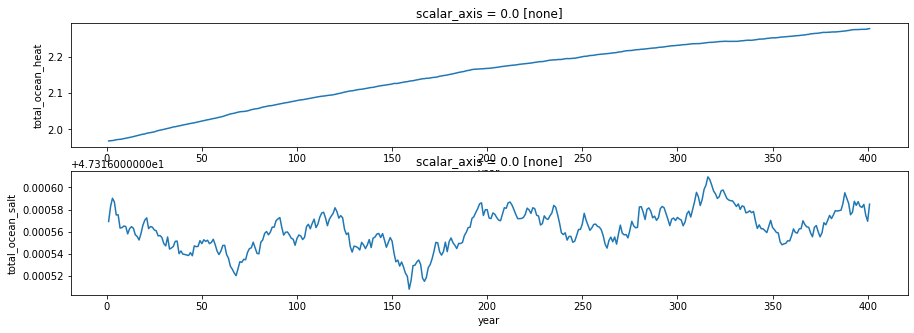

In [50]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(211)
toh_annual.plot()

plt.subplot(212)
tos_annual.plot()

In [51]:
# Save loaded data
toh_annual.to_netcdf(path_to_data + 'toh_annual.nc')
tos_annual.to_netcdf(path_to_data + 'tos_annual.nc')

#### Global average temperature and salinity

In [28]:
%%time
temp_global_ave = get_scalar_timeseries('temp_global_ave')

CPU times: user 7min 28s, sys: 30.4 s, total: 7min 59s
Wall time: 8min 38s


In [31]:
%%time
salt_global_ave = get_scalar_timeseries('salt_global_ave')

CPU times: user 7min 43s, sys: 23.2 s, total: 8min 6s
Wall time: 8min 46s


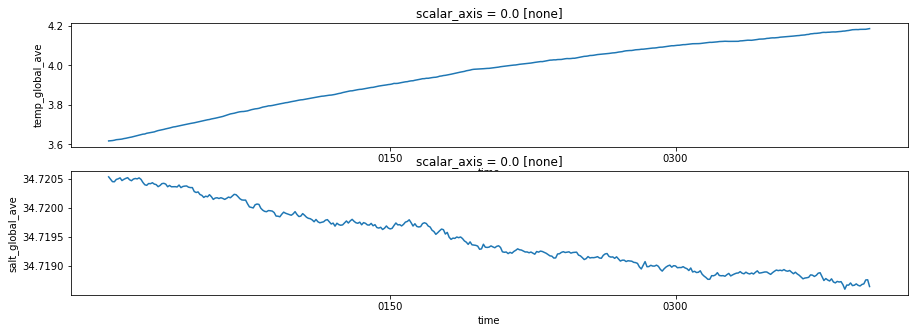

In [33]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(211)
temp_global_ave.plot()

plt.subplot(212)
salt_global_ave.plot()

In [35]:
# Save loaded data
temp_global_ave.to_netcdf(path_to_data + 'temp_global_ave_annual.nc')
salt_global_ave.to_netcdf('/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/' + 'salt_global_ave_annual.nc')

#### Global surface temperature and salinity

In [37]:
%%time
temp_surface_ave = get_scalar_timeseries('temp_surface_ave')

CPU times: user 7min 49s, sys: 21.8 s, total: 8min 11s
Wall time: 8min 54s


In [39]:
%%time
salt_surface_ave = get_scalar_timeseries('salt_surface_ave')

CPU times: user 7min 50s, sys: 21.4 s, total: 8min 12s
Wall time: 8min 51s


In [40]:
# Save loaded data
#temp_surface_ave.to_netcdf(path_to_data + 'temp_surface_ave_annual.nc')
salt_surface_ave.to_netcdf(path_to_data + 'salt_surface_ave_annual.nc')

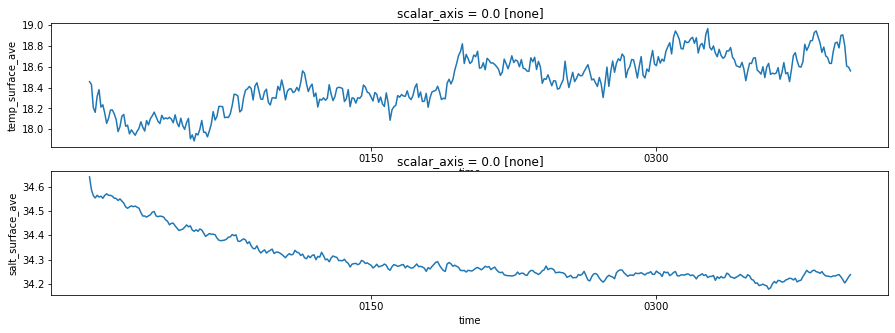

In [41]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(211)
temp_surface_ave.plot()

plt.subplot(212)
salt_surface_ave.plot()

What sets the variability in the SST?
- Look at upper 700 m temp
- Look at different basins
- Look at surface temperature maps

#### Kinetic energy

In [42]:
%%time
ke_tot = get_scalar_timeseries('ke_tot')

CPU times: user 7min 50s, sys: 22.3 s, total: 8min 13s
Wall time: 8min 53s


In [43]:
# Save loaded data
ke_tot.to_netcdf(path_to_data + 'ke_tot_annual.nc')

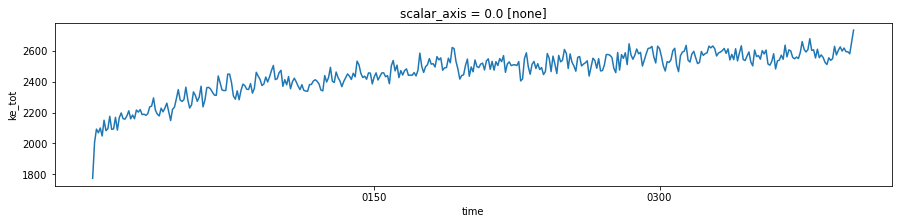

In [45]:
fig = plt.figure(figsize=(15, 3))

plt.subplot(111)
ke_tot.plot()

## Circulation diagnostics

### Transport through straits

In [33]:
straits = { 'DrakePassage': [-69.9, -69.9, -71.6, -51.0],
              'Lombok':     [-244.6, -243.9, -8.6, -8.6],
              'Ombai' :     [-235.0, -235.0, -9.2, -8.1],
              'Timor' :     [-235.9, -235.9, -11.9, -9.9],
              'Bering' :    [-172, -167, 65.8, 65.8],
              'Denmark' :   [-42, -22, 65.8, 65.8],
            }

In [37]:
rho = 1036 # kg/m^3, mean density of seawater

def calc_transport(expt, strait):
    """
    Calculate barotropic transport across a given 
     line of latitude or longitude.
     
    Designed for flow through straits.
    """
    
    xmin, xmax, ymin, ymax = straits[strait]
    
    if ymax>=65:
        raise ValueError('North of 65N the tripolar grid geometry brings complications and `.sum(''xt_ocean'')` is wrong!')
    
    print('Calculating {}: {} transport'.format(expt, strait))
    
    if xmin == xmax:       
        tx_trans = cc.querying.getvar(expt, 'tx_trans_int_z', session)
        transport = tx_trans.sel(xu_ocean=xmin, method='nearest')\
                            .sel(yt_ocean=slice(ymin, ymax))\
                            .sum('yt_ocean')/rho/1e6 #divide by ρ to convert to volume transport, m^3/s, and with 1e6 to convert to Sv.
        # tx_trans = cc.querying.getvar(expt,'tx_trans',session)
        # transport = tx_trans.sel(xu_ocean=xmin, method='nearest')\
        #                     .sel(yt_ocean=slice(ymin, ymax))\
        #                     .sum('st_ocean').sum('yt_ocean')/rho/1e6 #divide by ρ to convert to volume transport, m^3/s, and with 1e6 to convert to Sv.

    elif ymin == ymax:
        ty_trans = cc.querying.getvar(expt, 'ty_trans_int_z', session)
        transport = ty_trans.sel(yu_ocean=ymin, method='nearest')\
                            .sel(xt_ocean=slice(xmin, xmax))\
                            .sum('xt_ocean')/rho/1e6 #divide by ρ to convert to volume transport, m^3/s, and with 1e6 to convert to Sv.
        # ty_trans = cc.querying.getvar(expt,'ty_trans',session)
        # transport = ty_trans.sel(yu_ocean=ymin, method='nearest')\
        #                     .sel(xt_ocean=slice(xmin, xmax))\
        #                     .sum('st_ocean').sum('xt_ocean')/rho/1e6 #divide by ρ to convert to volume transport, m^3/s, and with 1e6 to convert to Sv.
    else:
        raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
    
    transport = transport.resample(time='Y').mean()
    transport = transport.compute()
       
    return transport

#### Drake Passage

In [22]:
%%time
transport = calc_transport(control, 'DrakePassage')

Calculating cj877:DrakePassage transport
CPU times: user 25min 42s, sys: 3min 27s, total: 29min 9s
Wall time: 33min 22s


In [23]:
transport

<xarray.DataArray 'tx_trans' (time: 4800)>
array([139.96094, 161.37067, 159.88766, ..., 215.936  , 214.32132,
       210.03018], dtype=float32)
Coordinates:
    xu_ocean  float64 -70.0
  * time      (time) object 0001-01-16 12:00:00 ... 0400-12-16 12:00:00

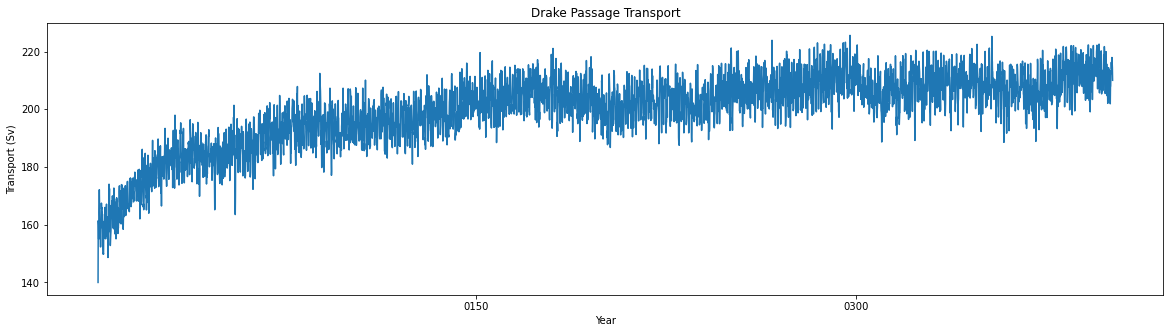

In [25]:
fig = plt.figure(figsize=(20,5))
transport.plot(linestyle='-')
plt.title('Drake Passage Transport')
plt.xlabel('Year')
plt.ylabel('Transport (Sv)');


#### Indonesian throughflow

In [38]:
%%time
Lombok = calc_transport(control, 'Lombok')

Calculating cj877: Lombok transport
CPU times: user 1min 14s, sys: 6.01 s, total: 1min 20s
Wall time: 1min 54s


In [40]:
# Save loaded data
Lombok.to_netcdf(path_to_data + 'Lombok_transport_annual.nc')

In [41]:
%%time
Ombai = calc_transport(control, 'Ombai')

Calculating cj877: Ombai transport
CPU times: user 1min 11s, sys: 5.75 s, total: 1min 16s
Wall time: 1min 44s


In [43]:
# Save loaded data
Ombai.to_netcdf(path_to_data + 'Ombai_transport_annual.nc')

In [44]:
%%time
Timor = calc_transport(control, 'Timor')

Calculating cj877: Timor transport
CPU times: user 1min 12s, sys: 5.79 s, total: 1min 18s
Wall time: 1min 45s


In [46]:
# Save loaded data
Timor.to_netcdf(path_to_data + 'Timor_transport_annual.nc')

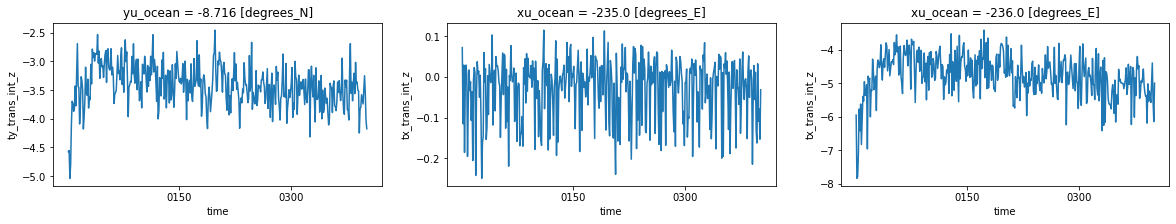

In [49]:
fig = plt.figure(figsize=(20, 3))

plt.subplot(131)
Lombok.plot()

plt.subplot(132)
Ombai.plot()

plt.subplot(133)
Timor.plot()

### Overturning

#### AABW overturning

In [5]:
def get_overturning(start_time, end_time, latitude):
    
    var = cc.querying.getvar(control, 'ty_trans_rho', session, start_time=start_time, end_time=end_time)
    var = var.sel(time=slice(start_time, end_time))
    psi_aabw = var.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')

    try:
        var2 = cc.querying.getvar(control, 'ty_trans_rho_gm', session, start_time=start_time, end_time=end_time)
        var2 = var2.sel(time=slice(start_time, end_time))
        psi_aabw_gm = var2.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
        psi_aabw_sum = psi_aabw_sum + psi_aabw_gm
    except:
        print('GM term not found')

    psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho')
    psi_aabw_sum = psi_aabw_sum.resample(time='Y').mean().compute()
    
    return psi_aabw_sum

In [7]:
%%time
# at 55$^{\circ}$S
psi_AABW_55S = get_overturning('0001-01-01', '0010-12-31', -55)

CPU times: user 48.3 s, sys: 5.67 s, total: 54 s
Wall time: 4min 44s


In [8]:
# Save loaded data
psi_AABW_55S.to_netcdf(path_to_data + 'psi_AABW_55S_annual.nc')

In [9]:
%%time
# at 30$^{\circ}$S
psi_AABW_30S = get_overturning('0001-01-01', '0002-12-31', -30)

CPU times: user 10.9 s, sys: 1.6 s, total: 12.5 s
Wall time: 1min 3s


In [ ]:
# Save loaded data
psi_AABW_30S.to_netcdf(path_to_data + 'psi_AABW_30S_annual.nc')

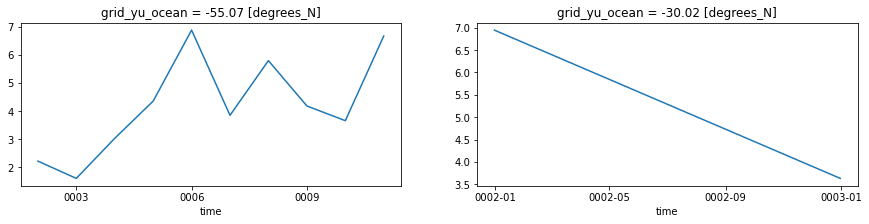

In [10]:
fig = plt.figure(figsize=(15,3))

plt.subplot(121)
psi_AABW_55S.plot()

plt.subplot(122)
psi_AABW_30S.plot()

#### AMOC overturning in density space 

In [29]:
def get_AMOC(start_time, end_time, latitude):
    
    if latitude == 26:
        xt_slice = slice(-103, -5)
    elif latitude == -30:
        xt_slice = slice(-60, 20)
    
    var = cc.querying.getvar(control, 'ty_trans_rho', session, start_time=start_time, end_time=end_time)
    var = var.sel(time=slice(start_time, end_time))
    psi_amoc = var.sel(grid_xt_ocean=xt_slice).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(control, 'ty_trans_rho_gm', session, start_time=start_time, end_time=end_time)
        var2 = var2.sel(time=slice(start_time, end_time))
        psi_amoc_gm = var2.sel(grid_xt_ocean=xt_slice).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho')
    psi_amoc_sum = psi_amoc_sum.resample(time='Y').mean().compute()

    return psi_amoc_sum

In [30]:
%%time
# at 26$^{\circ}$N
psi_amoc_26N = get_AMOC('0001-01-01', '0002-12-31', 26)

CPU times: user 5.44 s, sys: 1.2 s, total: 6.64 s
Wall time: 33.5 s


In [ ]:

# at 30$^{\circ}$S
psi_amoc_30S = get_AMOC('0001-01-01', '0002-12-31', -30)

#### NADW formation

### Area averages



- Overturning (NH and SH)
